In [1]:
!pip install catboost

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRanker, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score

In [3]:
data = pd.read_csv('intern_task.csv', sep=',')

In [4]:
print(data.info())
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235258 entries, 0 to 235257
Columns: 146 entries, rank to feature_143
dtypes: float64(140), int64(6)
memory usage: 262.1 MB
None


,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
0,0,10,1.0,0.0,1.0,3.0,3.0,0.333333,0.0,0.333333,...,0.0,0.000000,0.454545,0.890238,8.655534,1.000000,0.077778,0.002222,1.0,0.333333
1,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.773976,23.130514,0.000000,0.027826,0.000430,44.0,14.666667
2,0,10,3.0,0.0,2.0,0.0,3.0,1.000000,0.0,0.666667,...,0.0,0.000000,0.000000,0.918308,13.351339,0.000000,0.014925,0.000104,22.0,7.333333
3,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.975355,18.240926,0.000000,0.053140,0.000255,8.0,2.666667
4,2,10,3.0,0.0,3.0,1.0,3.0,1.000000,0.0,1.000000,...,273.0,79.670665,0.200000,0.990119,31.786048,0.333333,0.046512,0.000307,24.0,8.000000


In [5]:
df = data[data.isna().any(axis=1)]
df

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143


Как видно, только в одной строке присутствуют значения NaN, поэтому просто отбросим найденную строку.

In [6]:
data = data.dropna()
data = data.drop_duplicates()

In [7]:
for col in data.columns:
  if data[col].dtype != np.int64 and data[col].dtype != np.float64:
    print(col)
data = data.astype({'feature_119': 'float64'})

In [8]:
data['feature_119'].unique()

array([-19.589214, -15.792263, -17.982153, ...,  -6.943984,  -5.59747 ,
        -7.811665])

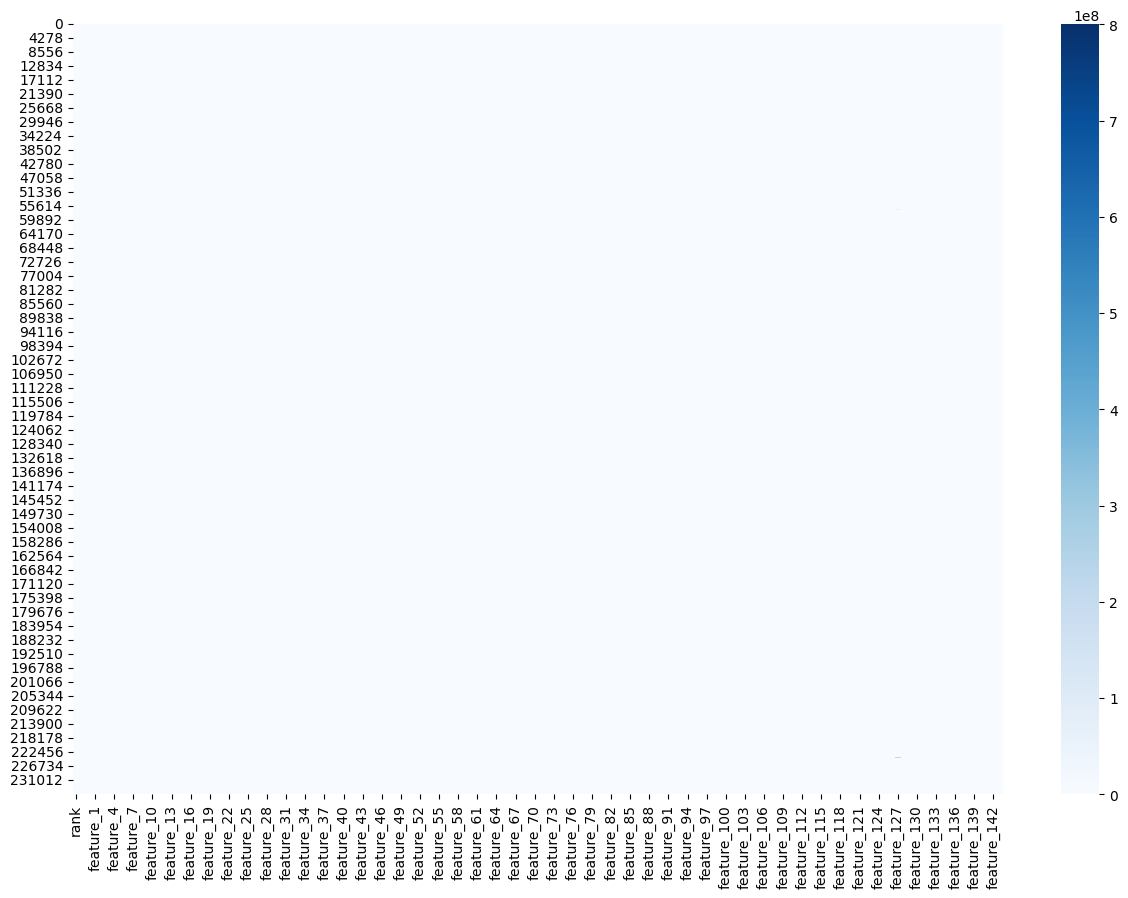

In [9]:
fig = plt.figure(figsize= (15,10))
sns.heatmap(data, cmap='Blues')
plt.show()

In [10]:
unique_items = data[2:].nunique()
good_cols = [i + 2 for i in range(144) if unique_items[i] > 40]
good_cols = [0, 1] + good_cols
data = data.iloc[:, good_cols]

Нужно сгруппировать по query_id.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('rank', axis=1),
                                                    data['rank'],
                                                    train_size=0.7,
                                                    random_state=42)
df_train = pd.DataFrame.join(X_train, y_train, how='left')
df_test = pd.DataFrame.join(X_test, y_test, how='left')
df_train = df_train.sort_values(by='query_id')
df_test = df_test.sort_values(by='query_id')

In [12]:
target = ['rank']
features = data.columns[2:]

train_pool = Pool(
    data = df_train[features],
    label = df_train[target],
    group_id = df_train['query_id'].tolist()
)

test_pool = Pool(
    data = df_test[features],
    label = df_test[target],
    group_id = df_test['query_id'].tolist()
)

In [13]:
model = CatBoostRanker(loss_function='YetiRank',
                       verbose=100,
                       random_seed=42)
model.fit(train_pool, early_stopping_rounds=100)
result = model.predict(test_pool)

0:	total: 643ms	remaining: 10m 42s
100:	total: 1m	remaining: 8m 58s
200:	total: 1m 56s	remaining: 7m 44s
300:	total: 2m 54s	remaining: 6m 45s
400:	total: 3m 49s	remaining: 5m 43s
500:	total: 4m 47s	remaining: 4m 46s
600:	total: 5m 43s	remaining: 3m 48s
700:	total: 6m 37s	remaining: 2m 49s
800:	total: 7m 33s	remaining: 1m 52s
900:	total: 8m 30s	remaining: 56.1s
999:	total: 9m 27s	remaining: 0us


In [14]:
model_ndcg = ndcg_score(
    [df_test[target].values.reshape((len(df_test[target].values),)).tolist()],
     [result.tolist()])
model_ndcg

0.9298207490068144

In [15]:
g = []
for i in unique_items:
  if i > 200:
    g.append(i)
print(len(g))

106
